<a href="https://colab.research.google.com/github/eigarces1/practica3Grupo12/blob/GRUPO12/practica3Grupo12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
#Upload kaggle.json with the API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download atharvasoundankar/global-cybersecurity-threats-2015-2024

Dataset URL: https://www.kaggle.com/datasets/atharvasoundankar/global-cybersecurity-threats-2015-2024
License(s): CC0-1.0
  0% 0.00/47.0k [00:00<?, ?B/s]
100% 47.0k/47.0k [00:00<00:00, 120MB/s]


In [ ]:
!unzip /content/global-cybersecurity-threats-2015-2024.zip

Archive:  /content/global-cybersecurity-threats-2015-2024.zip
  inflating: Global_Cybersecurity_Threats_2015-2024.csv  


In [ ]:
import os
import pandas as pd
import sqlite3

#Leer el CSV descargado
df = pd.read_csv("/content/Global_Cybersecurity_Threats_2015-2024.csv", encoding="UTF-8")
# Mostrar las primeras filas
df.shape

(3000, 10)

In [ ]:
df.head()

,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2019,Phishing,Education,80.53,773169,Hacker Group,Unpatched Software,VPN,63
1,China,2019,Ransomware,Retail,62.19,295961,Hacker Group,Unpatched Software,Firewall,71
2,India,2017,Man-in-the-Middle,IT,38.65,605895,Hacker Group,Weak Passwords,VPN,20
3,UK,2024,Ransomware,Telecommunications,41.44,659320,Nation-state,Social Engineering,AI-based Detection,7
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682,Insider,Social Engineering,VPN,68


# Tratamiento de datos

**Revisar información general del dataset**

In [ ]:
# Información general
df.info()

# Valores faltantes por columna
df.isnull().sum()

# Duplicados
df.duplicated().sum()

# Tipos de datos únicos por columna categórica
for col in ['Country', 'Year', 'Attack Type','Target Industry', 'Financial Loss (in Million $)', 'Number of Affected Users',
            'Attack Source','Security Vulnerability Type','Defense Mechanism Used', 'Incident Resolution Time (in Hours)']:
    print(f"\nColumna: {col}")
    print(df[col].unique()[:20])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              3000 non-null   object 
 1   Year                                 3000 non-null   int64  
 2   Attack Type                          3000 non-null   object 
 3   Target Industry                      3000 non-null   object 
 4   Financial Loss (in Million $)        3000 non-null   float64
 5   Number of Affected Users             3000 non-null   int64  
 6   Attack Source                        3000 non-null   object 
 7   Security Vulnerability Type          3000 non-null   object 
 8   Defense Mechanism Used               3000 non-null   object 
 9   Incident Resolution Time (in Hours)  3000 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 234.5+ KB

Columna: Country
['China' 'India' 'U

**Tratamiento de valores nulos y duplicados**

In [ ]:
# Duplicados
print("Duplicados:", df.duplicated().sum())
df = df.drop_duplicates()

# Verificar valores nulos
print("\nValores nulos por columna:\n", df.isnull().sum())

# Si hubiera nulos en numéricos, se reemplazan con 0
df['Financial Loss (in Million $)'] = df['Financial Loss (in Million $)'].fillna(0)
df['Number of Affected Users'] = df['Number of Affected Users'].fillna(0)
df['Incident Resolution Time (in Hours)'] = df['Incident Resolution Time (in Hours)'].fillna(0)

# Si hubiera nulos en categóricos, se reemplazan con 'Unknown'
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

Duplicados: 0

Valores nulos por columna:
 Country                                0
Year                                   0
Attack Type                            0
Target Industry                        0
Financial Loss (in Million $)          0
Number of Affected Users               0
Attack Source                          0
Security Vulnerability Type            0
Defense Mechanism Used                 0
Incident Resolution Time (in Hours)    0
dtype: int64


**Normalización de categorías y tipos de datos**

In [ ]:
# Normalizar texto (quitar espacios, poner formato consistente)
for col in categorical_cols:
    df[col] = df[col].str.strip().str.title()

# Asegurar tipos numéricos correctos
df['Year'] = df['Year'].astype(int)
df['Financial Loss (in Million $)'] = df['Financial Loss (in Million $)'].astype(float)
df['Number of Affected Users'] = df['Number of Affected Users'].astype(int)
df['Incident Resolution Time (in Hours)'] = df['Incident Resolution Time (in Hours)'].astype(int)

**Adaptación para análisis**

In [ ]:
# Impacto económico por usuario afectado
df['Impact Per User ($)'] = df.apply(
    lambda x: (x['Financial Loss (in Million $)'] * 1_000_000) / x['Number of Affected Users']
              if x['Number of Affected Users'] > 0 else 0, axis=1)

# Clasificación de ataques en crítico si el tiempo de resolución > 100 horas (ejemplo arbitrario)
df['IsCritical'] = df['Incident Resolution Time (in Hours)'].apply(lambda x: 1 if x > 100 else 0)

Nueva columna **IsCritical** para posterior análisis

In [ ]:
df.head()

,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours),Impact Per User ($),IsCritical
0,China,2019,Phishing,Education,80.53,773169,Hacker Group,Unpatched Software,Vpn,63,104.155754,0
1,China,2019,Ransomware,Retail,62.19,295961,Hacker Group,Unpatched Software,Firewall,71,210.129037,0
2,India,2017,Man-In-The-Middle,It,38.65,605895,Hacker Group,Weak Passwords,Vpn,20,63.789931,0
3,Uk,2024,Ransomware,Telecommunications,41.44,659320,Nation-State,Social Engineering,Ai-Based Detection,7,62.852636,0
4,Germany,2018,Man-In-The-Middle,It,74.41,810682,Insider,Social Engineering,Vpn,68,91.786915,0


# Análisis exploratorio de datos (EDA)

**Estadísticas descriptivas generales**

In [ ]:
# Resumen estadístico de las columnas numéricas
df.describe()

,Year,Financial Loss (in Million $),Number of Affected Users,Incident Resolution Time (in Hours),Impact Per User ($),IsCritical
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.0
mean,2019.570333,50.492970,504684.136333,36.476000,515.184504,0.0
std,2.857932,28.791415,289944.084972,20.570768,4325.834901,0.0
min,2015.000000,0.500000,424.000000,1.000000,0.620994,0.0
25%,2017.000000,25.757500,255805.250000,19.000000,49.862220,0.0
50%,2020.000000,50.795000,504513.000000,37.000000,100.312440,0.0
75%,2022.000000,75.630000,758088.500000,55.000000,202.896344,0.0
max,2024.000000,99.990000,999635.000000,72.000000,141058.020478,0.0


Con esto se puede ver el mínimo, máximo, media, porcentajes de variables como pérdidas económicas, usuarios afectados o tiempo de resolución.
Aquí ya se puede detectar outliers (por ejemplo, ataques con pérdidas demasiado altas o tiempos de resolución inusuales).

**Distribución de ataques por año**

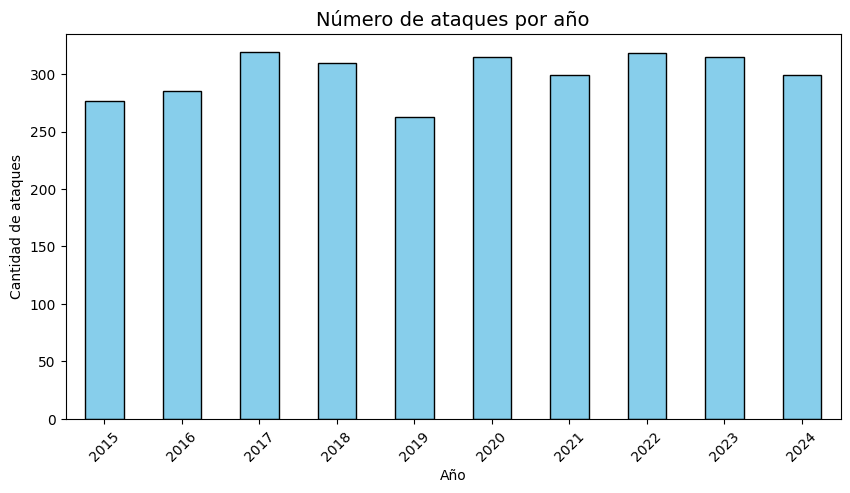

In [ ]:
import matplotlib.pyplot as plt

ataques_por_anio = df['Year'].value_counts().sort_index()

plt.figure(figsize=(10,5))
ataques_por_anio.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Número de ataques por año", fontsize=14)
plt.xlabel("Año")
plt.ylabel("Cantidad de ataques")
plt.xticks(rotation=45)
plt.show()

Podemos observar una tendencia creciente de ataques en los últimos años, y algo llamativo es la caida del año 2019

**Tipos de ataque más comunes**

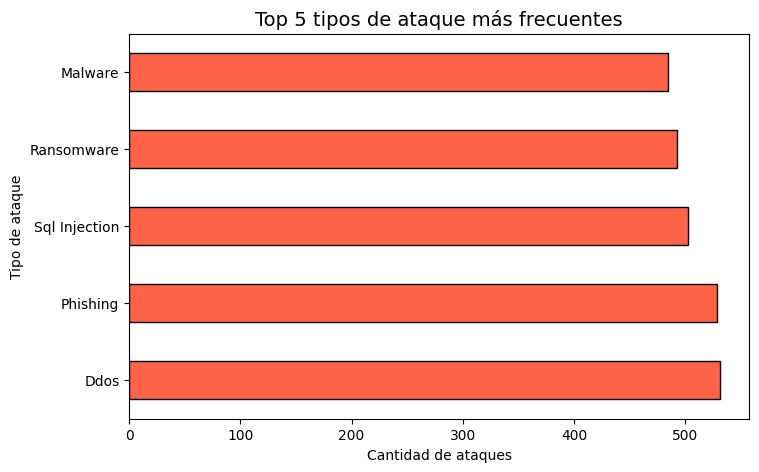

In [ ]:
df['Attack Type'].value_counts().head(5).plot(
    kind='barh', figsize=(8,5), color='tomato', edgecolor='black'
)
plt.title("Top 5 tipos de ataque más frecuentes", fontsize=14)
plt.xlabel("Cantidad de ataques")
plt.ylabel("Tipo de ataque")
plt.show()

Se observa que los ataques mas frecuentes son Phishing y DDoS

**Industrias más afectadas**

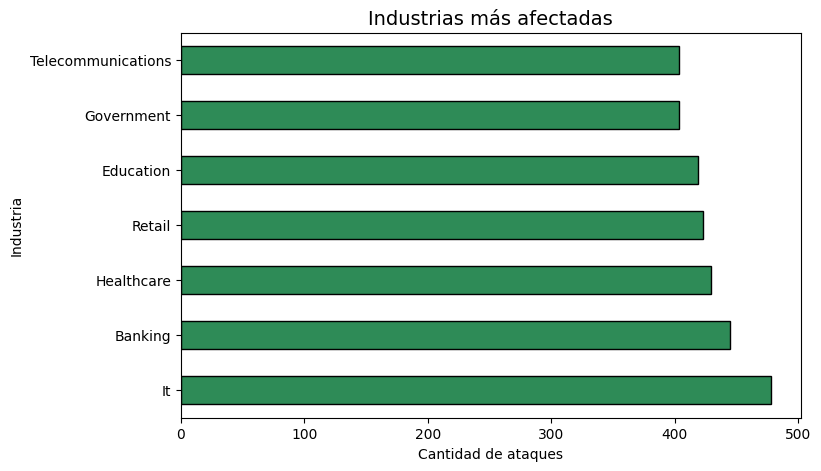

In [ ]:
df['Target Industry'].value_counts().head(10).plot(
    kind='barh', figsize=(8,5), color='seagreen', edgecolor='black'
)
plt.title("Industrias más afectadas", fontsize=14)
plt.xlabel("Cantidad de ataques")
plt.ylabel("Industria")
plt.show()

La industria mas afectada es la IT (Tecnología de la Información)

**Impacto económico**

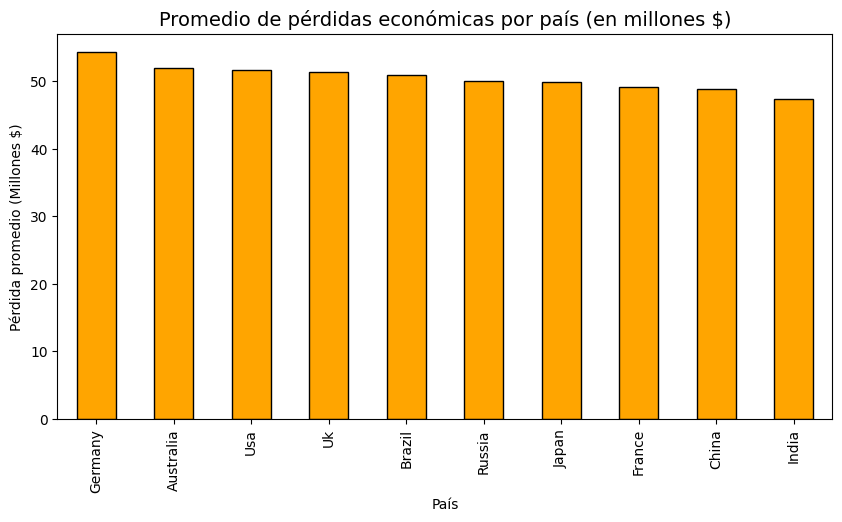

In [ ]:
impacto_paises = df.groupby("Country")["Financial Loss (in Million $)"].mean().sort_values(ascending=False).head(10)

impacto_paises.plot(kind='bar', figsize=(10,5), color='orange', edgecolor='black')
plt.title("Promedio de pérdidas económicas por país (en millones $)", fontsize=14)
plt.xlabel("País")
plt.ylabel("Pérdida promedio (Millones $)")
plt.show()

El país mas golpeado economicamente es Alemania, le siguen Australia y USA

**Tiempo de resolución de incidentes**

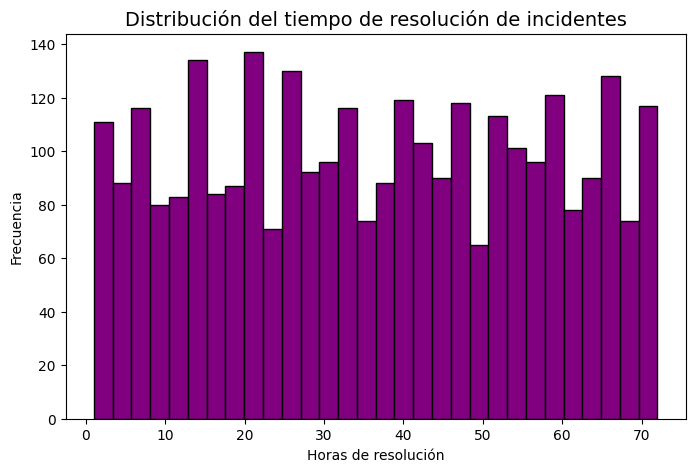

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(df["Incident Resolution Time (in Hours)"], bins=30, color="purple", edgecolor="black")
plt.title("Distribución del tiempo de resolución de incidentes", fontsize=14)
plt.xlabel("Horas de resolución")
plt.ylabel("Frecuencia")
plt.show()

La cola derecha es muy larga, hay ataques que tardan muchísimo en resolverse

**Relación entre variables**

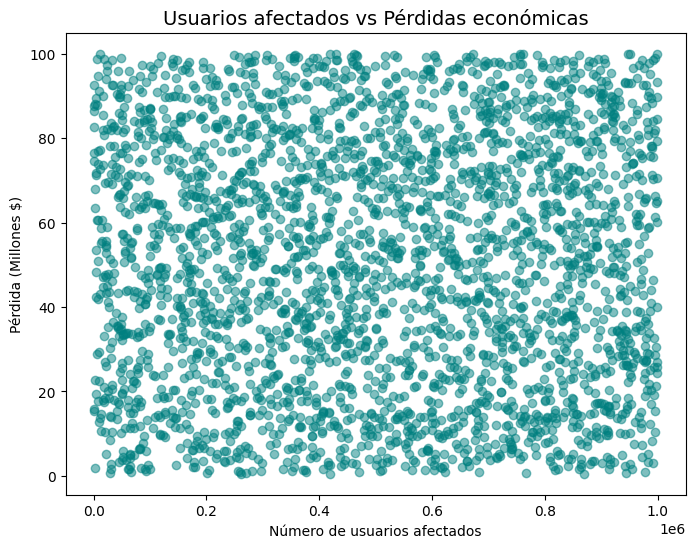

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df["Number of Affected Users"], df["Financial Loss (in Million $)"], alpha=0.5, color="teal")
plt.title("Usuarios afectados vs Pérdidas económicas", fontsize=14)
plt.xlabel("Número de usuarios afectados")
plt.ylabel("Pérdida (Millones $)")
plt.show()

Aparece un patrón ascendente, quiere decir que a más usuarios afectados, más pérdidas económicas

# Mejora en vizualización de datos

**Instalar y configurar librerías**

In [ ]:
!pip install seaborn plotly

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Estilo bonito de seaborn
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

**Evolución de ciberataques en el tiempo (Seaborn)**

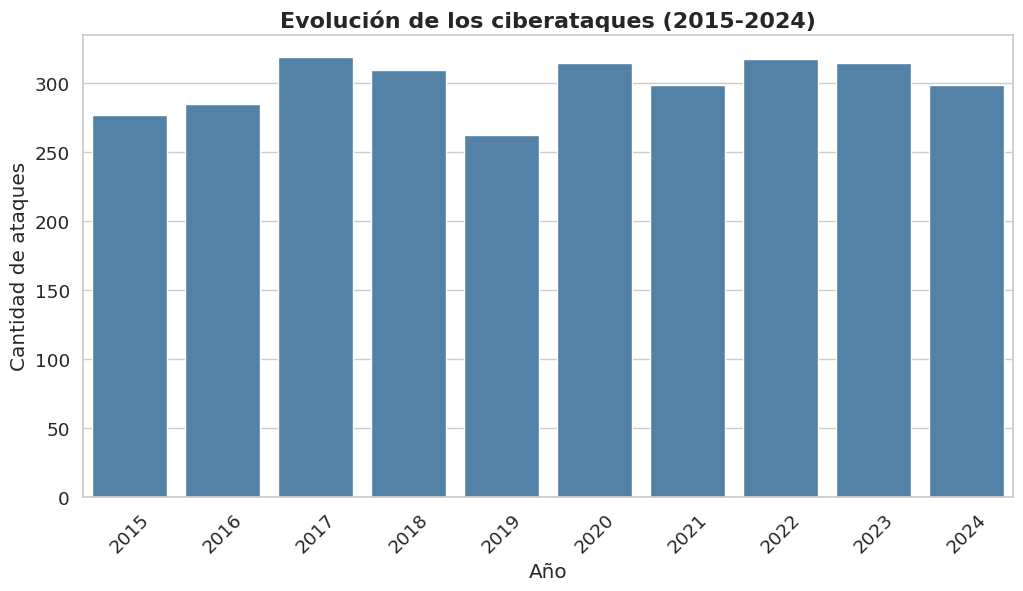

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x="Year", color="steelblue")
plt.title("Evolución de los ciberataques (2015-2024)", fontsize=16, weight='bold')
plt.xlabel("Año")
plt.ylabel("Cantidad de ataques")
plt.xticks(rotation=45)
plt.show()

**Tipos de ataque más comunes (Seaborn)**

/tmp/ipython-input-2453023794.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y="Attack Type", order=df["Attack Type"].value_counts().index, palette="viridis")


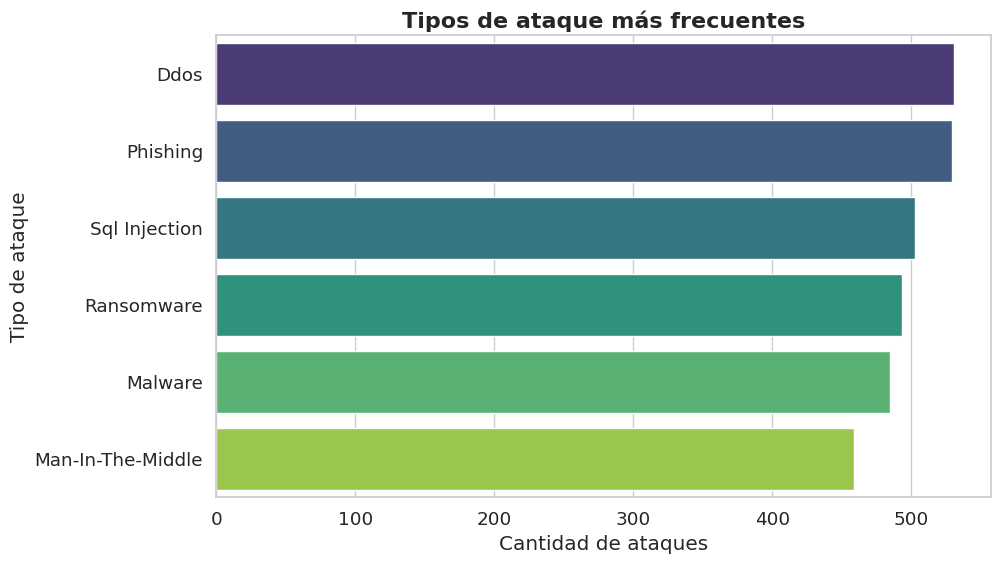

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, y="Attack Type", order=df["Attack Type"].value_counts().index, palette="viridis")
plt.title("Tipos de ataque más frecuentes", fontsize=16, weight='bold')
plt.xlabel("Cantidad de ataques")
plt.ylabel("Tipo de ataque")
plt.show()

**Impacto económico por país (Plotly)**

In [ ]:
fig = px.bar(
    df.groupby("Country")["Financial Loss (in Million $)"].mean().reset_index().sort_values(by="Financial Loss (in Million $)", ascending=False).head(15),
    x="Country",
    y="Financial Loss (in Million $)",
    title="Impacto económico promedio por país (Millones $)",
    color="Financial Loss (in Million $)",
    color_continuous_scale="OrRd"
)
fig.show()

**Industrias más afectadas (Seaborn)**

/tmp/ipython-input-2771255503.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




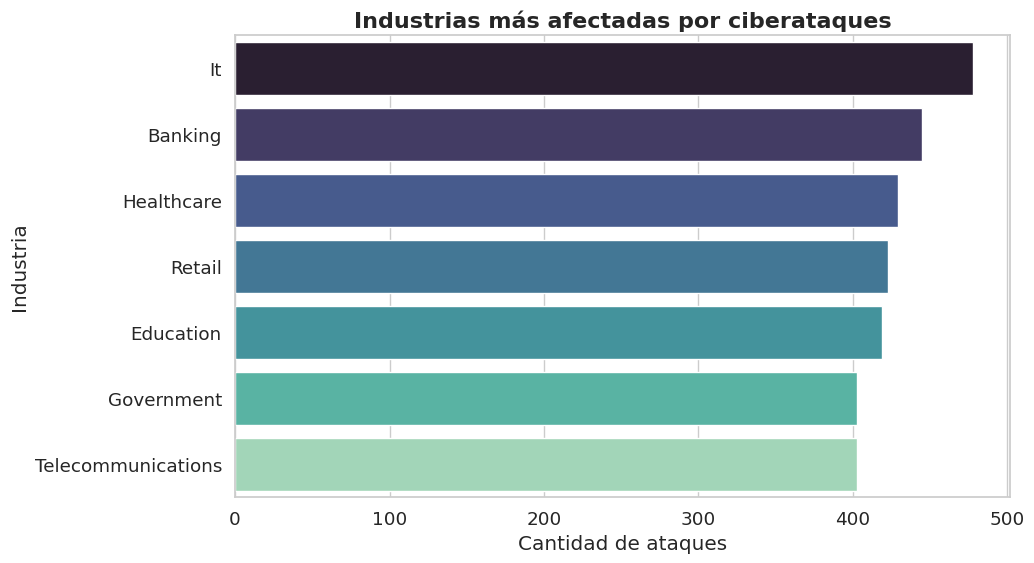

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, y="Target Industry", order=df["Target Industry"].value_counts().index, palette="mako")
plt.title("Industrias más afectadas por ciberataques", fontsize=16, weight='bold')
plt.xlabel("Cantidad de ataques")
plt.ylabel("Industria")
plt.show()

**Relación entre usuarios afectados y pérdidas económicas (Seaborn – Scatter)**

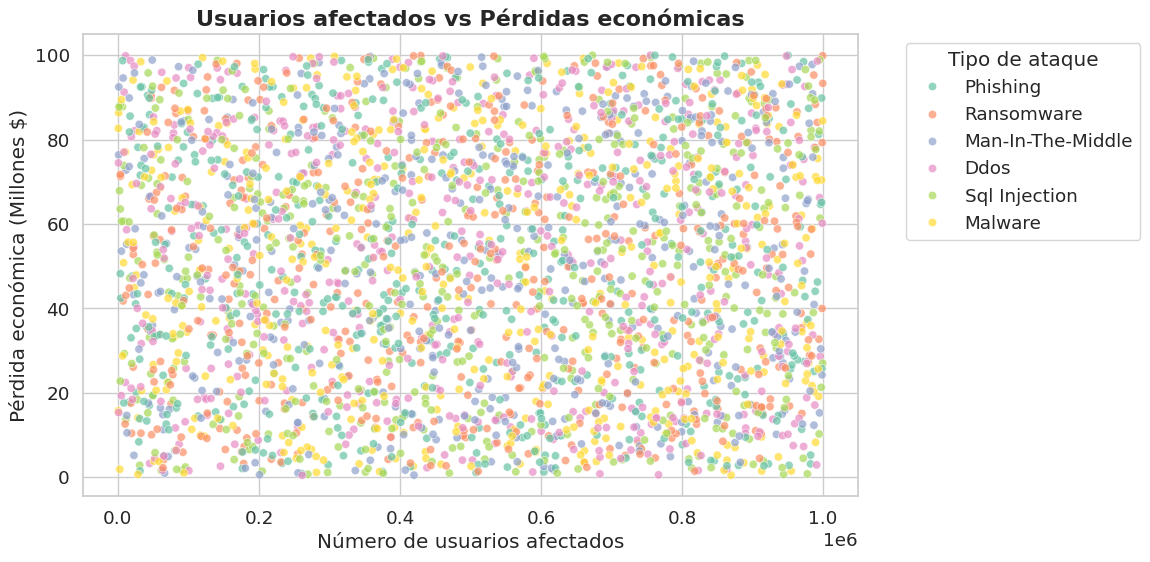

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x="Number of Affected Users",
    y="Financial Loss (in Million $)",
    hue="Attack Type",
    alpha=0.7,
    palette="Set2"
)
plt.title("Usuarios afectados vs Pérdidas económicas", fontsize=16, weight='bold')
plt.xlabel("Número de usuarios afectados")
plt.ylabel("Pérdida económica (Millones $)")
plt.legend(title="Tipo de ataque", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Conclusión del análisis: Relación entre usuarios afectados y pérdidas económicas**

El gráfico de dispersión revela que no existe una correlación directa y uniforme entre el número de usuarios afectados y las pérdidas económicas causadas por los ciberataques. De hecho:

1. **Alta dispersión de resultados:** Hay casos donde muchos usuarios están comprometidos pero las pérdidas son moderadas, y otros donde un número reducido de afectados conlleva consecuencias financieras muy elevadas.

2. **Importancia del tipo de ataque:** Al distinguir por tipo de ataque, se observa que amenazas como ransomware o DDoS suelen producir impactos económicos elevados aún con pocos usuarios afectados, mientras que ataques más comunes como phishing o malware tienden a generar menos pérdidas de forma más masiva.

Este hallazgo está respaldado por literatura especializada:
* Shevchenko et al. (2022) encontraron que no se identifica una relación consistente entre número de registros afectados y magnitud del daño, y que los eventos graves tienden a seguir distribuciones con colas pesadas (“heavy-tailed”), sugiriendo que unos pocos incidentes generan pérdidas extraordinariamente altas [1].
* El FMI también señala que aunque la mayoría de las pérdidas directas por incidentes cibernéticos son modestas, algunos eventos extremos pueden alcanzar cientos de millones de dólares, representando amenazas serias para la liquidez o solvencia de las empresas [2].
* Además, estudios como el de CybelAngel indican que en ataques tipo ransomware, los costos promedio de recuperación —sin incluir el rescate— pueden alcanzar 1.82 M USD, y los rescates en sí mismos suman otros millones, sin garantía de restauración completa de datos [3].

### Referencias  

[1] Shevchenko, P., Luo, X., Xiang, Y., & Ganesh, S. (2022). *Cyber Risk and Insurance: A Tale of Two Tails*. arXiv preprint. Disponible en: [https://arxiv.org/abs/2202.10189](https://arxiv.org/abs/2202.10189)  

[2] International Monetary Fund (IMF). (2023). *Cybersecurity and Financial Stability*. En Global Financial Stability Report, Capítulo 3. Disponible en: [https://www.elibrary.imf.org/display/book/9798400257704/CH003.xml](https://www.elibrary.imf.org/display/book/9798400257704/CH003.xml)  

[3] CybelAngel. (2021). *The True Cost of Ransomware Attacks*. Industry Report. Disponible en: [https://cybelangel.com/the-true-cost-of-ransomware-attacks/](https://cybelangel.com/the-true-cost-of-ransomware-attacks/)  

**Síntesis**
* El impacto económico de un ciberataque no depende simplemente de cuántos usuarios resultan afectados, sino de la naturaleza del ataque y de su objetivo o sector vulnerado.
* Existen eventos aislados con efectos devastadores que distorsionan cualquier tendencia central, lo que subraya la necesidad de evaluar los riesgos desde una perspectiva más allá de las estadísticas promedio.

**Mapa de ataques por país (Plotly)**

In [ ]:
fig = px.choropleth(
    df,
    locations="Country",
    locationmode="country names",
    color="Financial Loss (in Million $)",
    hover_name="Country",
    animation_frame="Year",  # evolución en el tiempo
    title="Mapa mundial de pérdidas económicas por ciberataques",
    color_continuous_scale="Reds"
)
fig.show()